### Loading the database

In [19]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder 
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
                            f1_score, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report 

In [3]:
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('social.csv')
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


### Data Cleaning & Preprocessing

In [5]:
data.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [6]:
# Irrelevant to our use case
data = data.drop('User ID', axis=1)
data

,Gender,Age,EstimatedSalary,Purchased
0,Male,19.0,19000.0,0
1,Male,35.0,20000.0,0
2,Female,26.0,43000.0,0
3,Female,27.0,57000.0,0
4,Male,19.0,76000.0,0
...,...,...,...,...
395,Female,46.0,41000.0,1
396,Male,51.0,23000.0,1
397,Female,50.0,20000.0,1
398,Male,36.0,33000.0,0


In [7]:
data['Age'] = data['Age'].astype(float)
data['Purchased'] = data['Purchased'].astype(int)

### Binary Encoding

In [8]:
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1}).astype(int)
data['Gender']

0      0
1      0
2      1
3      1
4      0
      ..
395    1
396    0
397    1
398    0
399    1
Name: Gender, Length: 400, dtype: int32

### Feature Selection

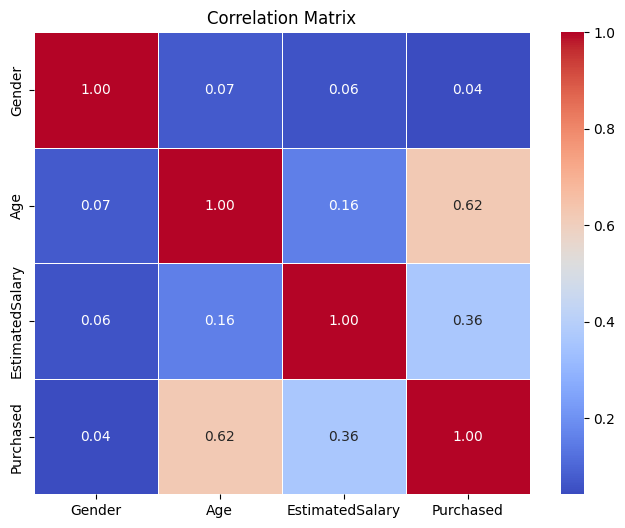

In [9]:
correlation_matrices = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrices, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
# Gender shows irrelevant Corelation thus we drop it
data = data.drop('Gender', axis=1)

### Feature Enhinering

In [11]:
# Define the target and the inputs

target = data['Purchased']
inputs = data.drop(['Purchased'], axis=1)

# Create a training and a testing dataset
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.3, random_state=608, stratify = target)

#### Stratification
- When subpopulations within an overall population vary, it could be advantageous to sample each subpopulation (stratum) independently.
- Stratification is the process of dividing members of the population into homogeneous subgroups before sampling.

In [12]:
y_train.value_counts(normalize = True)


Purchased
0    0.642857
1    0.357143
Name: proportion, dtype: float64

In [13]:
pd.Series(y_test).value_counts(normalize = True)


Purchased
0    0.641667
1    0.358333
Name: proportion, dtype: float64

In [14]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train_rescaled = scaling.transform(x_train)

In [15]:
C = 1.0
svc = svm.SVC(kernel='linear', C=C).fit(x_train_rescaled, y_train)

In [16]:
y_pred_test = svc.predict(scaling.transform(x_test))

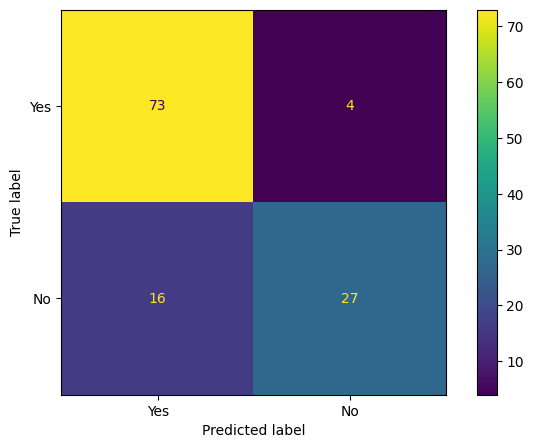

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_test),
    display_labels=["Yes", "No"],
)

cmp.plot(ax=ax);

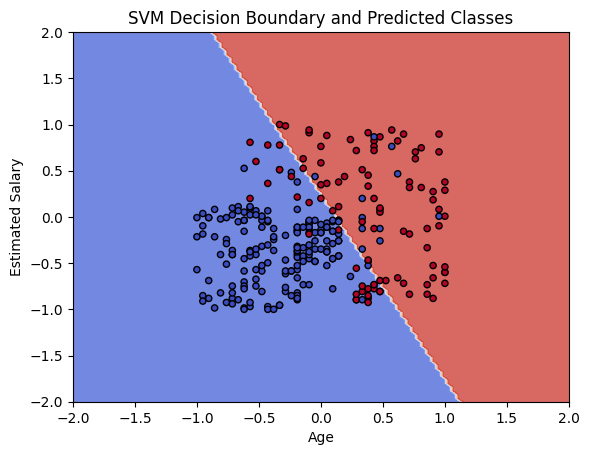

In [20]:
# Define the ranges for Age and EstimatedSalary
age_min, age_max = x_train_rescaled[:, 0].min() - 1, x_train_rescaled[:, 0].max() + 1
salary_min, salary_max = x_train_rescaled[:, 1].min() - 1, x_train_rescaled[:, 1].max() + 1

# Create a mesh-grid of points to evaluate the model's predictions
age_range = np.linspace(age_min, age_max, 100)
salary_range = np.linspace(salary_min, salary_max, 100)
xx, yy = np.meshgrid(age_range, salary_range)
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# Obtain predicted classes for each point in the mesh-grid
Z = svc.predict(mesh_points)
Z = Z.reshape(xx.shape)

# Plot decision boundary and predicted classes
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x_train_rescaled[:, 0], x_train_rescaled[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.title('SVM Decision Boundary and Predicted Classes')
plt.show()

In [21]:
print(classification_report(y_test, y_pred_test, target_names = ["Yes", "No"]))

              precision    recall  f1-score   support

         Yes       0.82      0.95      0.88        77
          No       0.87      0.63      0.73        43

    accuracy                           0.83       120
   macro avg       0.85      0.79      0.80       120
weighted avg       0.84      0.83      0.83       120



### Tuning hyper-parameters

In [22]:
tuned_parameters = [
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"], "C":[1, 10]},
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10]}
]
scores = ["precision", "recall"]

In [23]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(x_train_rescaled, y_train)

    # Print only the best parameters and their corresponding score 
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()

    # Print the mean and standard deviation of the scores for each parameter setting
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    # Print the detailed classification report
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(scaling.transform(x_test))
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:
{'C': 1, 'kernel': 'poly'}

Grid scores on development set:

0.849 (+/-0.080) for {'C': 1, 'kernel': 'linear'}
0.841 (+/-0.073) for {'C': 10, 'kernel': 'linear'}
0.861 (+/-0.099) for {'C': 1, 'kernel': 'poly'}
0.834 (+/-0.081) for {'C': 10, 'kernel': 'poly'}
0.321 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.321 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.771 (+/-0.109) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.321 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.78      0.95      0.85        77
           1       0.85      0.51      0.64        43

    accuracy                           0.79       120
   macro avg       0.81      0.73      0.75

c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

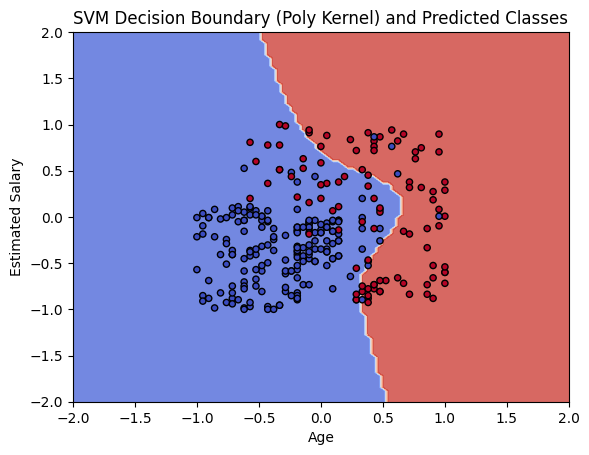

In [24]:
# Create and train the SVM model with the specified hyperparameters
svc_poly = svm.SVC(kernel='poly', C=1)
svc_poly.fit(x_train_rescaled, y_train)

# Define the ranges for Age and EstimatedSalary
age_min, age_max = x_train_rescaled[:, 0].min() - 1, x_train_rescaled[:, 0].max() + 1
salary_min, salary_max = x_train_rescaled[:, 1].min() - 1, x_train_rescaled[:, 1].max() + 1

# Create a meshgrid of points to evaluate the model's predictions
age_range = np.linspace(age_min, age_max, 100)
salary_range = np.linspace(salary_min, salary_max, 100)
xx, yy = np.meshgrid(age_range, salary_range)
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# Obtain predicted classes for each point in the meshgrid
Z = svc_poly.predict(mesh_points)
Z = Z.reshape(xx.shape)

# Plot decision boundary and predicted classes
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x_train_rescaled[:, 0], x_train_rescaled[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.title('SVM Decision Boundary (Poly Kernel) and Predicted Classes')
plt.show()